In [2]:
import os
os.environ["MXNET_CUDNN_LIB_CHECKING"] = "0"
os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"
import sys
path_to_adds = [r"D:\Source\Test", 
                r"D:\Source\Test\TextMxnet\examples\polygonExtractor", 
                r"D:\Source\Test\TextMxnet\examples\Metadata.py", 
                r"D:\Source\Test\TextMxnet\examples\image_Dictionary.py", 
                r"D:\Source\Test\TextMxnet\examples\myModel.py",
                r"D:\Source\Test\TextMxnet\examples\myPlots.py"]
for path_to_add in path_to_adds:
    if path_to_add not in sys.path:
        sys.path.append(path_to_add)
        
# Remove duplicates while preserving order
sys.path = list(dict.fromkeys(sys.path))

import mxnet as mx
from mxnet import nd, autograd


Function to load images and masks and Preprocessing

In [3]:
from image_Dictionary import ImageDict
from sklearn.model_selection import train_test_split

images = ImageDict( r"D:\Source\Test\data\2022\BB\08X_Features_Multi", False)
image_dict = images.load_tif_files()
masks = ImageDict(r"D:\Source\Test\data\2022\BB\XX_Reference_Masks_ResUNetA", True)
mask_dict = masks.load_tif_files()
train_ids, val_ids = train_test_split(list(image_dict.keys()), test_size=0.2, random_state=42)
print(len(image_dict))

648


In [4]:
batch_size = 8
learning_rate = 0.001
num_classes = 2
ctx = mx.cpu()  
depth = 6
nfilters_init = 32

In [ ]:
from my_Train import myTrain
my_train = myTrain(images, masks, image_dict, mask_dict, train_ids, val_ids)
my_train.trainModel()

In [6]:
import myModel
import myPlots
print(myModel.__file__)
from importlib import reload
reload(myModel)
print(myPlots.__file__)
reload(myPlots)

d:\Source\Test\TextMxnet\examples\myModel.py
d:\Source\Test\TextMxnet\examples\myPlots.py


<module 'myPlots' from 'd:\\Source\\Test\\TextMxnet\\examples\\myPlots.py'>

Starting visualization
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


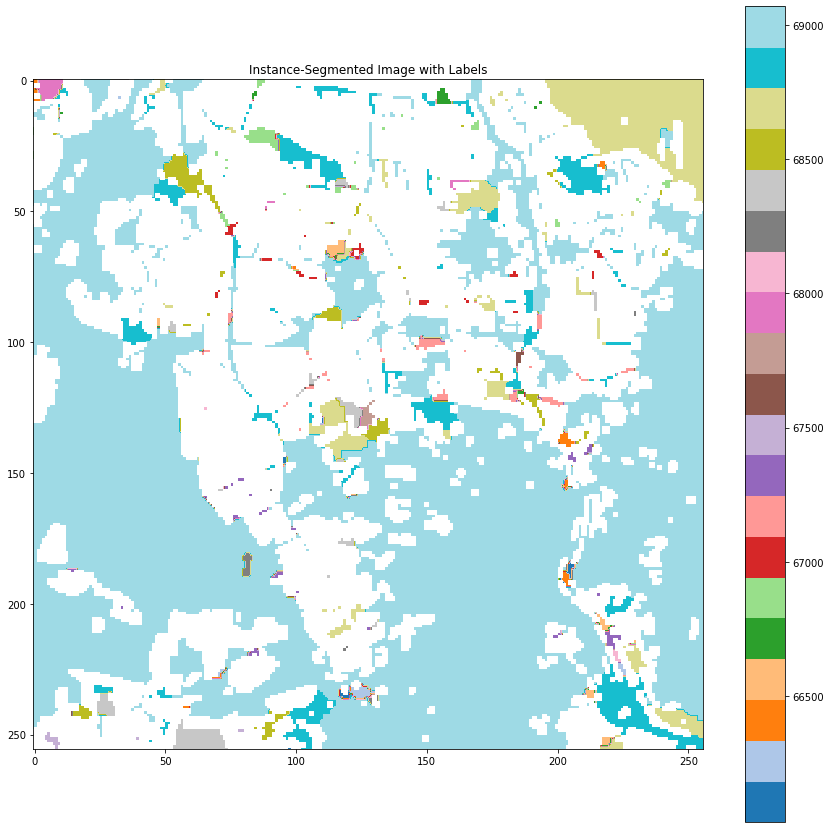

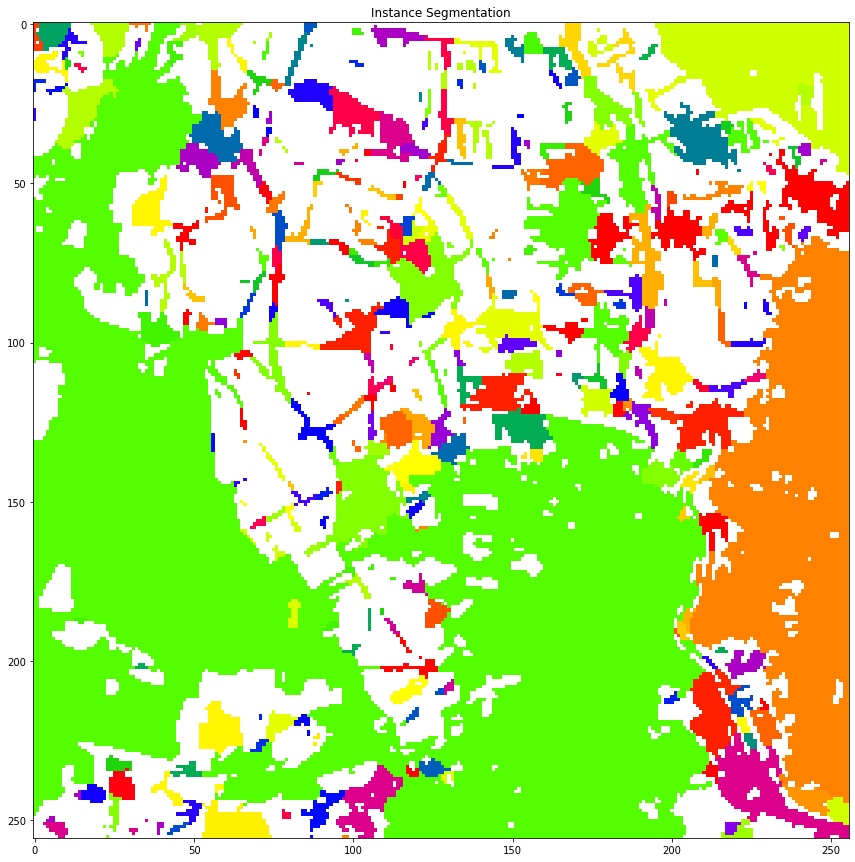

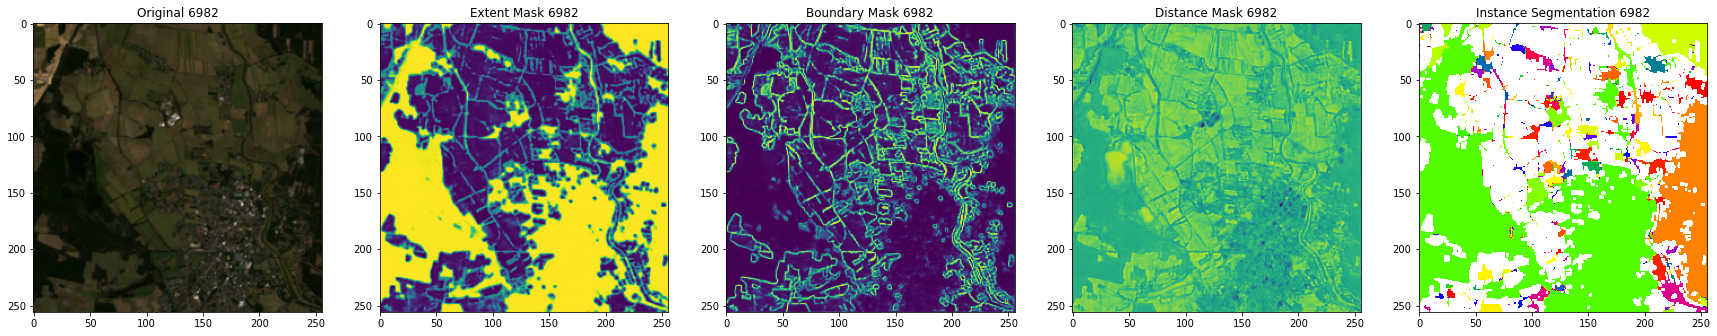

In [7]:
from decode.postprocessing.instance_segmentation import InstSegm
from myPlots import visualize_segmentation, visualize_all
result_path = r"D:\Source\Test\data\Output\Fractal\Result"

def visualize_predictions(path, t_ext = 0.2,t_bound = 0.15, num_images=1):    
    print("Starting visualization")
     
    netPredict = myModel.MyFractalResUNetcmtsk(True, path, ctx, 32, depth, num_classes)
    for id in val_ids[:num_images]:  # Limit to 'num_images' for visualization
        img = images.getImage(id, image_dict)
        currentMetadata = image_dict[id]
        with autograd.record():  
            outputs = netPredict.net(img)  
            pred_segm  = outputs[0][0,1,:,:].asnumpy()
            pred_bound = outputs[1][0,1,:,:].asnumpy()
            inst =InstSegm(pred_segm, pred_bound, t_ext=t_ext, t_bound=t_bound)   # perform instance segmentation
            visualize_segmentation(id, inst, result_path)
            visualize_all(id, img, currentMetadata, outputs, pred_segm, pred_bound, inst)
            return inst

inst= visualize_predictions(r"D:\Source\Test\data\Output\Fractal\Model_VNIR_params\model_VNIR_49.params")

In [8]:
from polygon_extractor import PolygonExtractor

predicted_image = nd.array(inst)  
ground_truth_image = nd.array(mask_dict[6982].image)
extractor  = PolygonExtractor()
pred_polygons, gt_polygons =extractor.getPolygons(predicted_image, ground_truth_image)
print(len(pred_polygons))
print(len(gt_polygons))

348
263


In [ ]:
from compute_iou import ComputeIou
comIou =ComputeIou(pred_polygons,gt_polygons)
iou_results= comIou.calculateIOU()

In [ ]:
for i, (pred_polygon, gt_polygon, iou) in enumerate(iou_results):
    print(f"Result {i+1}: IoU = {iou}")

In [ ]:
# Evaluate using the precomputed IoU results
precision, recall, f1_score = comIou.evaluate_segmentation_from_iou(iou_results, iou_threshold=0.5)

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")